In [1]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import time
import cv2
import pytesseract
import math
import cv2

In [2]:
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", type=str,
# 	help="path to input image")
# ap.add_argument("-east", "--east", type=str,
# 	help="path to input EAST text detector")
# ap.add_argument("-c", "--min-confidence", type=float, default=0.5,
# 	help="minimum probability required to inspect a region")
# ap.add_argument("-w", "--width", type=int, default=320,
# 	help="resized image width (should be multiple of 32)")
# ap.add_argument("-e", "--height", type=int, default=320,
# 	help="resized image height (should be multiple of 32)")
# args = vars(ap.parse_args())

In [3]:
min_confidence = 0.5
width = 960
height = 960
args = {
        'image' : './q.jpg',
        'east' : './frozen_east_text_detection.pb', 
        'min_confidence' : min_confidence,
        'width' : width, 
        'height' : height}

In [4]:
# load the input image and grab the image dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]

tesseractOutputImage = np.zeros_like(orig)

# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = W / float(newW)
rH = H / float(newH)

# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [5]:
from matplotlib import pyplot as plt
plt.get_backend()

plt.show()
plt.imshow(image)
plt.show()
plt.imshow(tesseractOutputImage)
plt.show()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [6]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [7]:
# load the pre-trained EAST text detector
print("EAST text detector reading")
net = cv2.dnn.readNet(args["east"])

EAST text detector reading


In [8]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()



# show timing information on text prediction
print("text detection took {:.6f} seconds".format(end - start))

text detection took 3.630088 seconds


In [9]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

# loop over the number of rows
for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
        # if our score does not have sufficient probability, ignore it
        if scoresData[x] < args["min_confidence"]:
            continue

        # compute the offset factor as our resulting feature maps will
        # be 4x smaller than the input image
        (offsetX, offsetY) = (x * 4.0, y * 4.0)

        # extract the rotation angle for the prediction and then
        # compute the sin and cosine
        angle = anglesData[x]
        cos = np.cos(angle)
        sin = np.sin(angle)

        # use the geometry volume to derive the width and height of
        # the bounding box
        h = xData0[x] + xData2[x]
        w = xData1[x] + xData3[x]

        # compute both the starting and ending (x, y)-coordinates for
        # the text prediction bounding box
        endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
        endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
        startX = int(endX - w)
        startY = int(endY - h)
        # add the bounding box coordinates and probability score to
        # our respective lists
        rects.append((startX, startY, endX, endY))
        confidences.append(scoresData[x])

In [10]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

329 219 562 253
Text Scale:  0.6852135042936126
Text Thickness:  1.0355555555555556


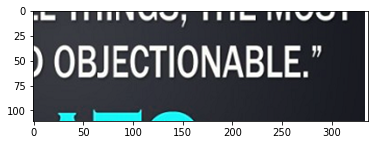

Text: ) OBJECTIONABLE.”
345 47 556 81
Text Scale:  0.7032395680575922
Text Thickness:  1.055


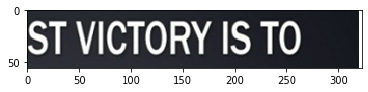

Text: SYA (C1(0) a SO
425 161 601 195
Text Scale:  0.5865884548726836
Text Thickness:  0.88


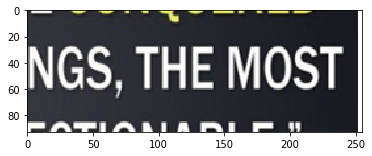

Text: NGS, THE MOST |
40 218 238 254
Text Scale:  0.8998363933830212
Text Thickness:  1.32


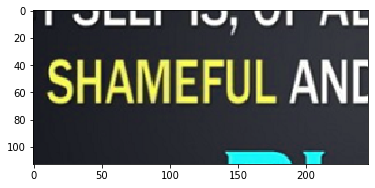

Text: Sy alt U ae
353 103 582 144
Text Scale:  0.8177403228110269
Text Thickness:  1.2213333333333334


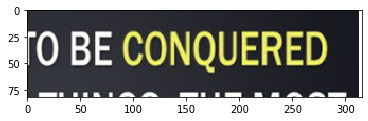

Text: ON TAKON UTD |
73 47 282 81
Text Scale:  0.6965737901613117
Text Thickness:  1.045


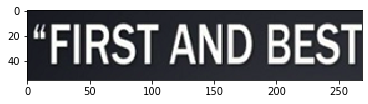

Text: “FIRST AND BEST
41 102 243 144
Text Scale:  0.7768035686817412
Text Thickness:  1.1542857142857144


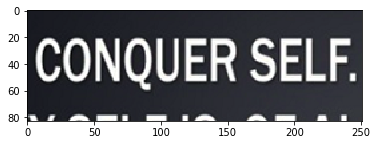

Text: CONQUER SELF.
222 161 427 197
Text Scale:  0.9316487911288855
Text Thickness:  1.3666666666666665


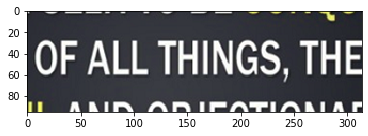

Text: OVER CSA La
170 287 415 347
Text Scale:  1.7495001428163384
Text Thickness:  2.45


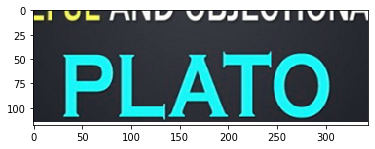

Text: Se \ren
10 159 231 195
Text Scale:  0.690538682664667
Text Thickness:  1.04


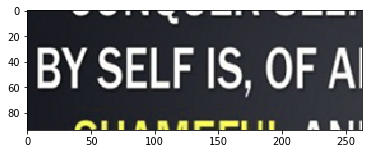

Text: BY SELF IS, OF A
162 101 438 136
Text Scale:  0.6272157076629398
Text Thickness:  0.96


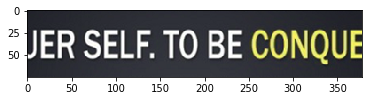

Text: JER SELF. TO BE CONQUE


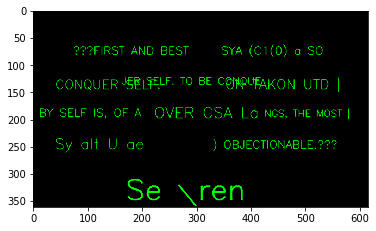

True

In [11]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

# loop over the bounding boxes
#---Tesseract 
origTesseract = orig.copy()
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    #----tessaract
    extraPixelsX = 0.85
    extraPixelsY = 0.85
    croppedImage = origTesseract[int(startY*extraPixelsY):int(endY/extraPixelsY), int(startX*extraPixelsX):int(endX/extraPixelsX)]
    config = ('-l eng --oem 3 --psm 6')
    text = pytesseract.image_to_string(croppedImage, config=config)
    plt.imshow(croppedImage)
    print(startX, startY, endX, endY)
    textScale = (2.0*(endX-startX)/200.0)/(len(text)+0.002)*5
    textThickness = max(4*(endX-startX)/200/(len(text)+1)*4, 0)
    print("Text Scale: ", textScale)
    print("Text Thickness: ", textThickness)
    cv2.putText(tesseractOutputImage, str(text), (startX,endY), cv2.FONT_HERSHEY_SIMPLEX, textScale, (0, 255, 0), int(textThickness), lineType = cv2.LINE_AA)
    plt.imshow(croppedImage)
    plt.show()
    print("Text:", str(text))

plt.imshow(tesseractOutputImage)
plt.show()
cv2.imwrite("tesseract Detection-"+str(min_confidence)+"-"+str(width)+"-"+str(height)+".jpg", tesseractOutputImage)


#Draw bbox
for (startX, startY, endX, endY) in boxes:
    # scale the bounding box coordinates based on the respective
    # ratios
    startX = int(startX * rW)
    startY = int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)

    # draw the bounding box on the image
#     cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

    

    
    
# show the output image
# cv2.imshow("Text Detection"+, orig)
# cv2.waitKey(0)
cv2.imwrite("Text Detection-"+str(min_confidence)+"-"+str(width)+"-"+str(height)+".jpg", orig)


In [12]:
import pytesseract
import cv2
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
img_cv = cv2.imread('q.jpg')
img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

In [13]:
print(pytesseract.image_to_string(img_rgb))

“FIRST AND BEST VICTORY IS TO
CONQUER SELF. TO BE CONQUERED
BY SELF IS, OF ALL THINGS, THE MOST
SHAMEFUL AND OBJECTIONABLE.”

PLATO


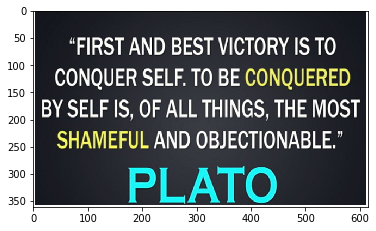

In [14]:
plt.imshow(img_cv)